In [1]:
import math

import cv2
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd

from skimage import feature
from skimage.feature import hog
from skimage import data, exposure
from scipy.signal import convolve2d

import image_slicer

from cascid.configs import pad_ufes
from cascid import image_preprocessing, image_sampling



## Loading dataframes

In [3]:
METADATA = "../../../data/PAD-UFES/metadata.csv"
IMAGES = "../../../data/PAD-UFES/images/"

In [4]:
df = pd.read_csv(METADATA)
df.head().transpose()

0                   1  \
patient_id                        PAT_1516              PAT_46   
lesion_id                             1765                 881   
smoke                                  NaN               False   
drink                                  NaN               False   
background_father                      NaN           POMERANIA   
background_mother                      NaN           POMERANIA   
age                                      8                  55   
pesticide                              NaN               False   
gender                                 NaN              FEMALE   
skin_cancer_history                    NaN                True   
cancer_history                         NaN                True   
has_piped_water                        NaN                True   
has_sewage_system                      NaN                True   
fitspatrick                            NaN                   3   
region                                 ARM                NECK   
diameter_1                             NaN                   6   
diameter_2                             NaN                   5   
diagnostic                             NEV                 BCC   
itch                                 False                True   
grew                                 False                True   
hurt                                 False               False   
changed                              False                True   
bleed                                False                True   
elevation                            False                True   
img_id               PAT_1516_1765_530.png  PAT_46_881_939.png   
biopsed                              False                True   

                                         2                      3  \
patient_id                        PAT_1545               PAT_1989   
lesion_id                             1867                   4061   
smoke                                  NaN                    NaN   
drink                                  NaN                    NaN   
background_father                      NaN                    NaN   
background_mother                      NaN                    NaN   
age                                     77                     75   
pesticide                              NaN                    NaN   
gender                                 NaN                    NaN   
skin_cancer_history                    NaN                    NaN   
cancer_history                         NaN                    NaN   
has_piped_water                        NaN                    NaN   
has_sewage_system                      NaN                    NaN   
fitspatrick                            NaN                    NaN   
region                                FACE                   HAND   
diameter_1                             NaN                    NaN   
diameter_2                             NaN                    NaN   
diagnostic                             ACK                    ACK   
itch                                  True                   True   
grew                                 False                  False   
hurt                                 False                  False   
changed                              False                  False   
bleed                                False                  False   
elevation                            False                  False   
img_id               PAT_1545_1867_547.png  PAT_1989_4061_934.png   
biopsed                              False                  False   

                                        4  
patient_id                        PAT_684  
lesion_id                            1302  
smoke                               False  
drink                                True  
background_father               POMERANIA  
background_mother               POMERANIA  
age                                    79  
pesticide                           False 

### Hand-picked images containing hairs


In [5]:
hair_ids = [
    "PAT_691", "PAT_320", "PAT_109", "PAT_356", "PAT_681", "PAT_167",
    "PAT_2109", "PAT_245", "PAT_633"
]


##### Creating dataframe with hair images

In [6]:
df_hair_test = df[df["patient_id"].isin(hair_ids)]
df_hair_test.head().transpose()

170                  201  \
patient_id                        PAT_691              PAT_167   
lesion_id                            1311                  258   
smoke                               False                False   
drink                                True                False   
background_father               POMERANIA              GERMANY   
background_mother                 GERMANY              GERMANY   
age                                    56                   58   
pesticide                            True                 True   
gender                               MALE                 MALE   
skin_cancer_history                 False                 True   
cancer_history                      False                 True   
has_piped_water                     False                False   
has_sewage_system                    True                False   
fitspatrick                             1                    1   
region                            FOREARM                 FACE   
diameter_1                             20                   10   
diameter_2                             15                    7   
diagnostic                            BCC                  BCC   
itch                                False                 True   
grew                                False                 True   
hurt                                False                 True   
changed                              True                 True   
bleed                               False                 True   
elevation                            True                 True   
img_id               PAT_691_1311_686.png  PAT_167_258_711.png   
biopsed                              True                 True   

                                      274                  434  \
patient_id                        PAT_691              PAT_109   
lesion_id                            3994                  868   
smoke                               False                 True   
drink                                True                 True   
background_father               POMERANIA                ITALY   
background_mother                 GERMANY                ITALY   
age                                    56                   82   
pesticide                            True                 True   
gender                               MALE                 MALE   
skin_cancer_history                 False                False   
cancer_history                      False                 True   
has_piped_water                     False                False   
has_sewage_system                    True                False   
fitspatrick                             1                    2   
region                            FOREARM                  EAR   
diameter_1                             10                    6   
diameter_2                             10                    6   
diagnostic                            ACK                  MEL   
itch                                False                False   
grew                                False                 True   
hurt                                False                False   
changed                              True                 True   
bleed                               False                False   
elevation                            True                False   
img_id               PAT_691_3994_671.png  PAT_109_868_723.png   
biopsed                             False                 True   

                                      447  
patient_id                        PAT_691  
lesion_id                            1310  
smoke                               False  
drink                                True  
background_father               POMERANIA  
background_mother                 GERMANY  
age                                    56  
pesticide                            True  
gender                               MALE  
skin_cancer_history             

# Removing hairs: Hessian Method

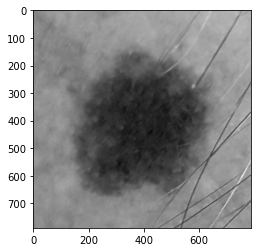

In [10]:
filename = df_hair_test['img_id'].iloc[7]
filename = IMAGES +  filename
img = cv2.imread(filename)
img = cv2.cvtColor(img, cv2.COLOR_BGR2GRAY)
plt.imshow(img, cmap='gray')
plt.show()

In [11]:
H_elems = feature.hessian_matrix(img, sigma=1, order='rc')
result = feature.hessian_matrix_eigvals(H_elems)

In [12]:
for item in result:
    print(np.min(item), np.max(item))

-0.04231774172630397 0.08737159026628444
-0.09270593887031786 0.013257050094094454


In [13]:
img_black_hair = result[0]
img_black_hair[img_black_hair < 0] = 0

img_white_hair = -result[1]
img_white_hair[img_white_hair < 0] = 0

In [14]:
img_paper_black_hair = (3.0 * result[0] + result[1]) / 2.0
img_paper_white_hair = (3.0 * result[1] + result[0]) / 2.0


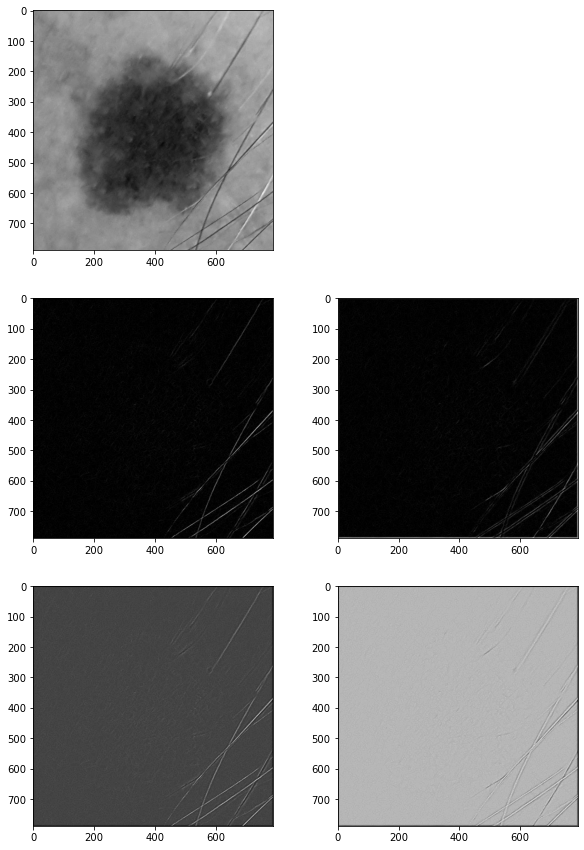

In [17]:
plt.figure(figsize=(10, 15))
plt.subplot(3, 2, 1)
plt.imshow(img, cmap='gray')
plt.subplot(3, 2, 3)
plt.imshow(img_black_hair, cmap='gray')
plt.subplot(3, 2, 4)
plt.imshow(img_white_hair, cmap='gray')
plt.subplot(3, 2, 5)

plt.imshow(img_paper_black_hair, cmap='gray')
plt.subplot(3, 2, 6)
plt.imshow(img_paper_white_hair, cmap='gray')
plt.show()

In [18]:
def remove_hairs(img):
    gray = cv2.cvtColor(img, cv2.COLOR_BGR2GRAY)
    H_elems = feature.hessian_matrix(gray, sigma=1, order='rc')
    result = feature.hessian_matrix_eigvals(H_elems)
    
    
    img_black_hair = result[0]
    img_black_hair[img_black_hair < 0] = 0

    img_white_hair = -result[1]
    img_white_hair[img_white_hair < 0] = 0
    
    img_paper_black_hair = (3.0 * result[0] + result[1]) / 2.0
    img_paper_white_hair = (3.0 * result[1] + result[0]) / 2.0
    
    img_paper_black_hair_t= np.float32(result[0] > 0.02)
    img_paper_white_hair_t = np.float32(result[1] < -0.02)

    ret, thresh_black = cv2.threshold(img_paper_black_hair_t, np.median(img_paper_black_hair), 255, cv2.THRESH_BINARY)
    ret, thresh_white = cv2.threshold(img_paper_white_hair_t, np.median(img_paper_white_hair), 255, cv2.THRESH_BINARY)

    dst_black = cv2.inpaint(img,img_paper_black_hair_t.astype('uint8'),2,cv2.INPAINT_TELEA)
    dst_white = cv2.inpaint(dst_black,img_paper_white_hair_t.astype('uint8'),2,cv2.INPAINT_TELEA)

    dst_black_t = cv2.inpaint(img,thresh_black.astype('uint8'),2,cv2.INPAINT_TELEA)
    dst_white_t = cv2.inpaint(img,thresh_white.astype('uint8'),2,cv2.INPAINT_TELEA)
    
    return ( dst_black, dst_white, dst_black_t, dst_white_t, thresh_black, thresh_white, img_paper_black_hair,  img_paper_white_hair, img_paper_black_hair_t, img_paper_white_hair_t )

In [20]:
def load_selected_img(n):
    filename = df_hair_test['img_id'].iloc[n]
    filename = IMAGES +  filename
    img = cv2.imread(filename)[:,:,::-1]
    plt.imshow(img, cmap=plt.cm.gray)
    plt.show()
    return img

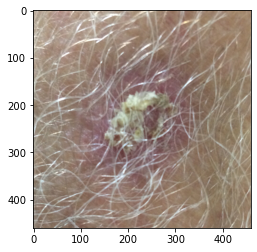

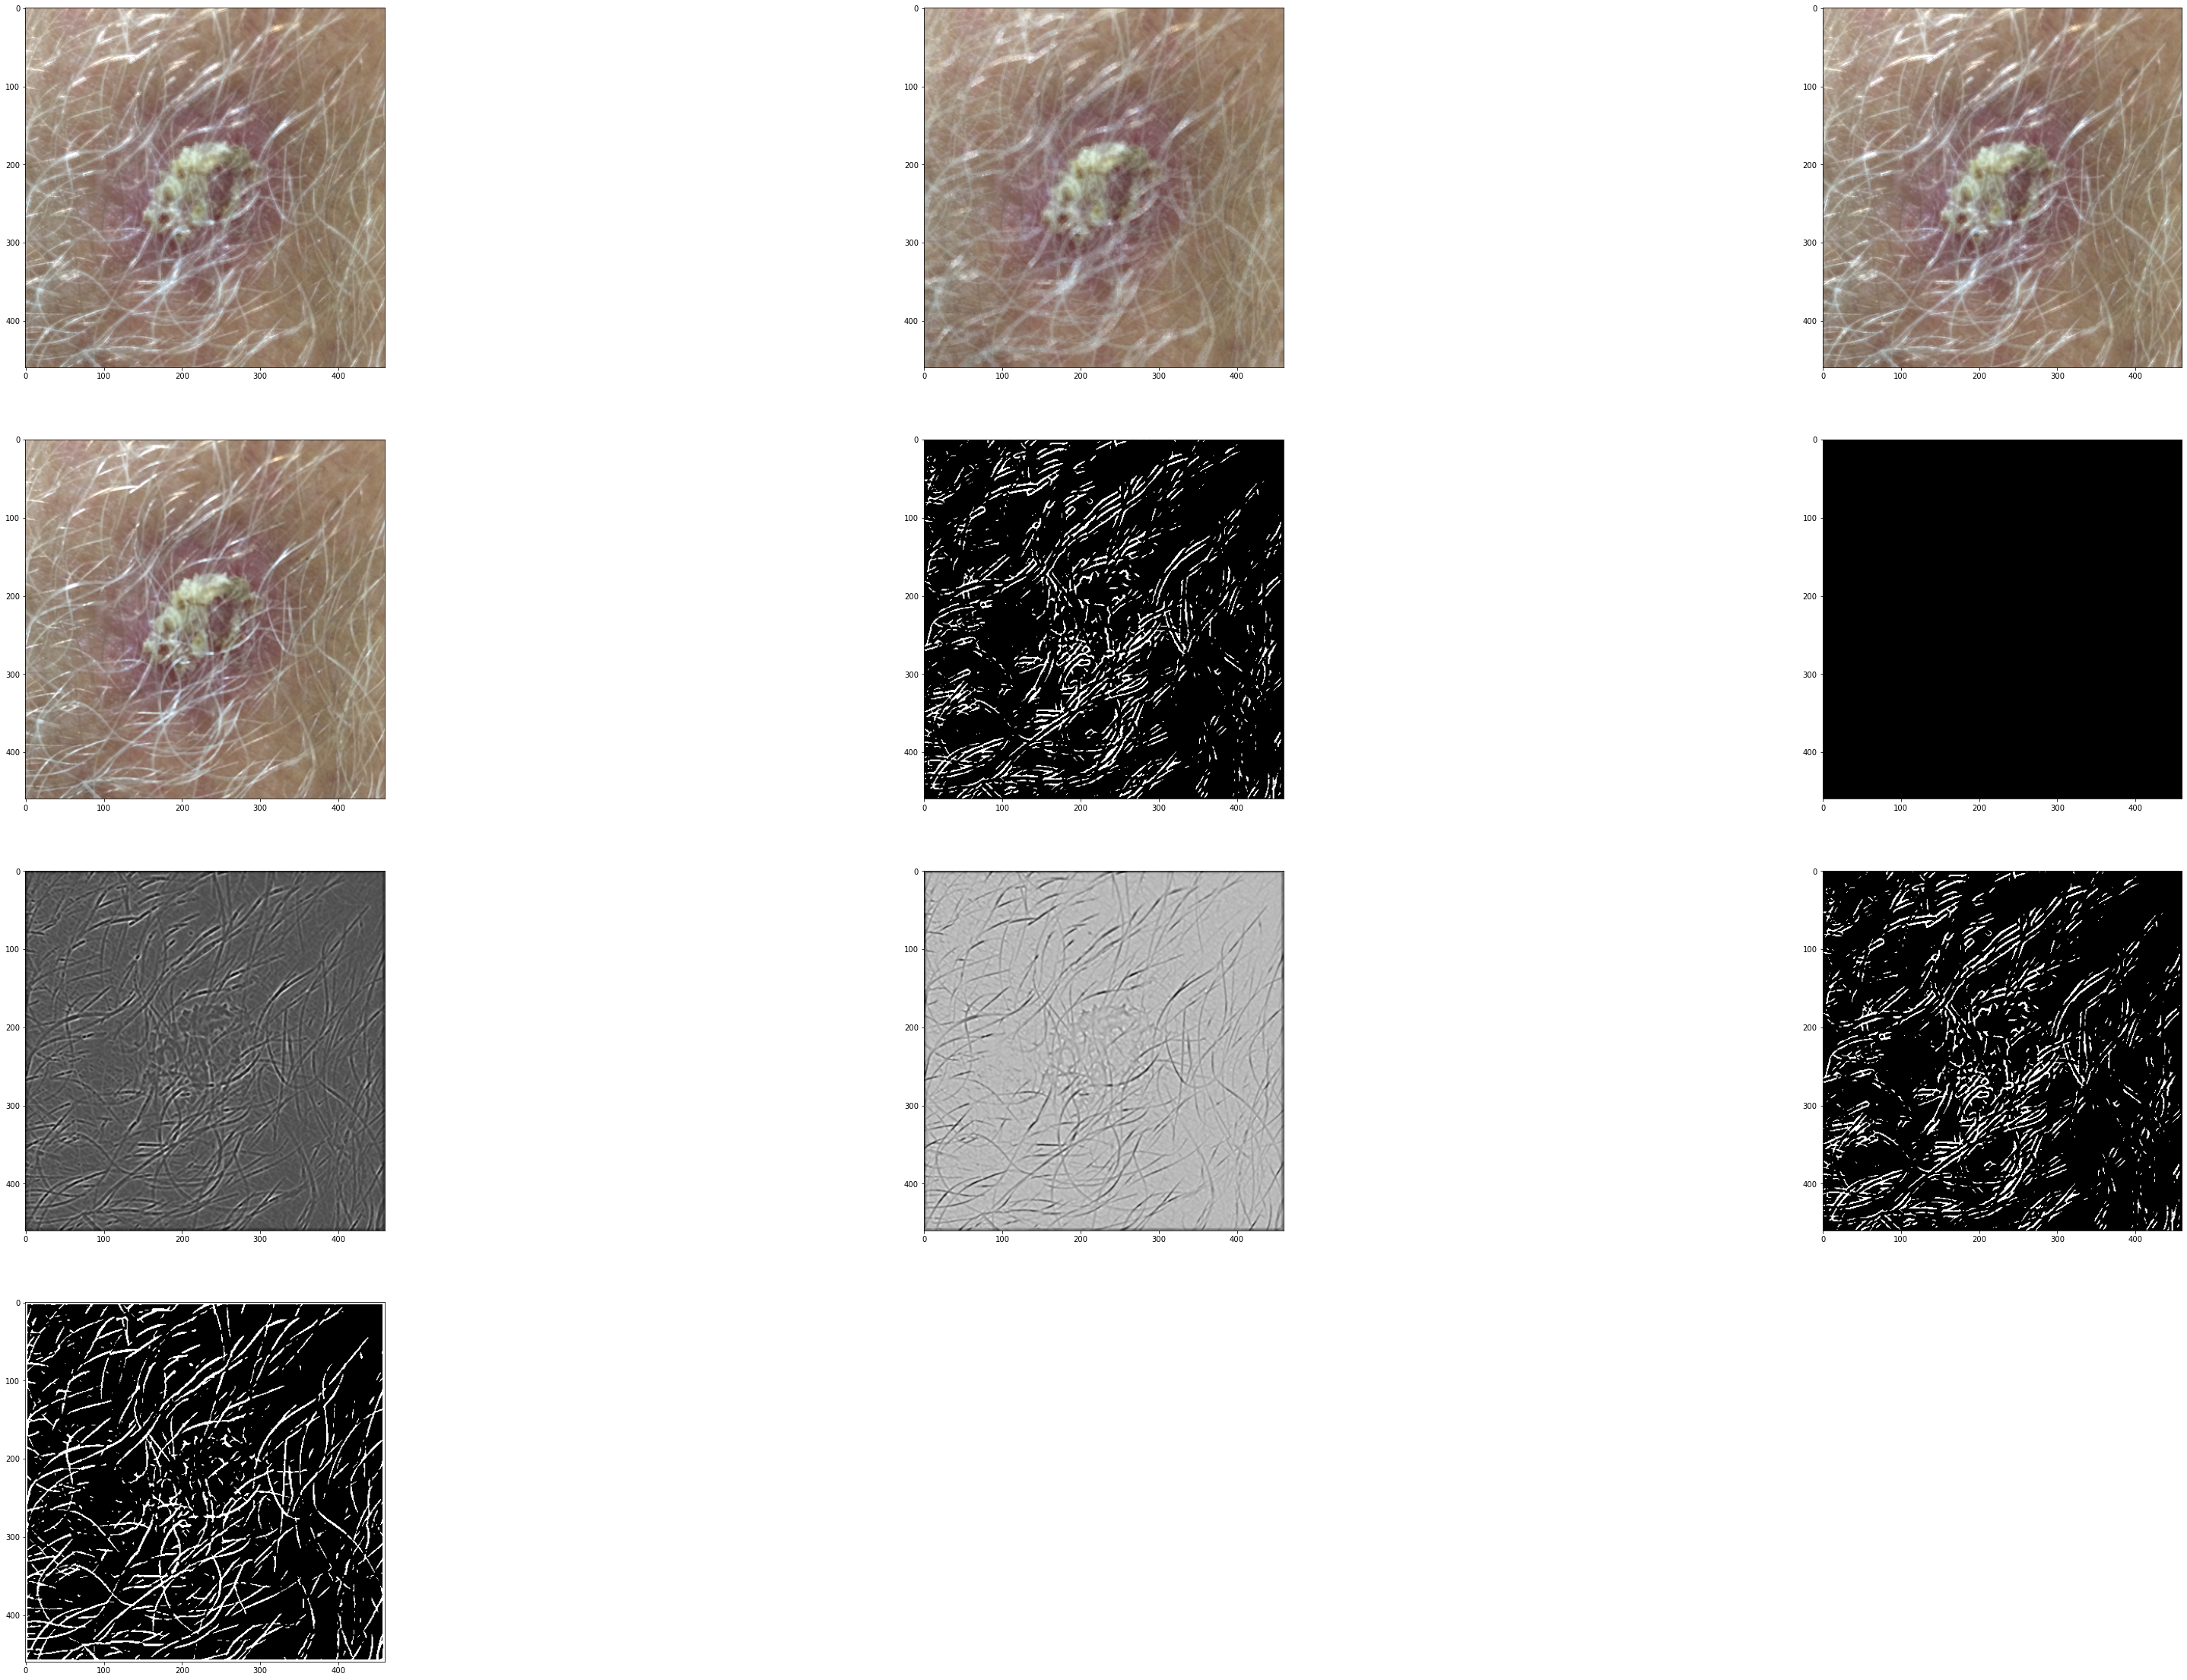

In [21]:
img = load_selected_img(0)
results = remove_hairs(img)
image_sampling.image_grid(results)

# HOG test

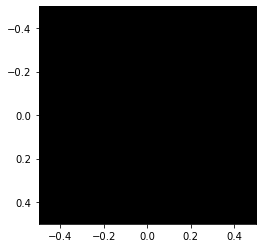

In [22]:
filename = df_hair_test['img_id'].iloc[0]
filename = str(pad_ufes.IMAGES_DIR / filename)
img = cv2.imread(filename)

fd, hog_image = hog(img, orientations=8, pixels_per_cell=(16, 16),
                    cells_per_block=(1, 1), visualize=True)

hog_image_rescaled = exposure.rescale_intensity(hog_image, in_range=(0, 10))

plt.imshow(hog_image_rescaled, cmap=plt.cm.gray)


# Derivative of Gaussian (DOG) Method
##### Hair removal methods: A comparative study for dermoscopy images

In [23]:
# Hair removal methods: A comparative study for dermoscopy images
# https://faculty.uca.edu/ecelebi/documents/BSPC_2011.pdf
# https://notebook.community/darshanbagul/ComputerVision/EdgeDetection-ZeroCrossings/EdgeDetectionByZeroCrossings

def hair_removal_dog(img):
        DoG_kernel = [
                    [0,   0, -1, -1, -1, 0, 0],
                    [0,  -2, -3, -3, -3,-2, 0],
                    [-1, -3,  5,  5,  5,-3,-1],
                    [-1, -3,  5, 16,  5,-3,-1],
                    [-1, -3,  5,  5,  5,-3,-1],
                    [0,  -2, -3, -3, -3,-2, 0],
                    [0,   0, -1, -1, -1, 0, 0]
                ] 
        gray = cv2.cvtColor(img, cv2.COLOR_BGR2GRAY)
        dog_img = convolve2d(gray, DoG_kernel, mode="same")

        dog_img[dog_img >= 255] = 0

        bitwiseNot = cv2.bitwise_not(dog_img)

        mask = np.zeros(bitwiseNot.shape, np.uint8)
        mask[bitwiseNot > 250] = 255
        
        kernel = np.ones((3,3),np.uint8)
        dilation = cv2.dilate(mask.astype('uint8'),kernel,iterations = 1)

        final_img = cv2.inpaint(img,dilation,1,cv2.INPAINT_NS)

        closing = cv2.morphologyEx(final_img, cv2.MORPH_CLOSE, kernel)

        return(bitwiseNot, mask, dilation, final_img, closing)


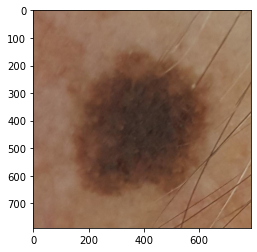

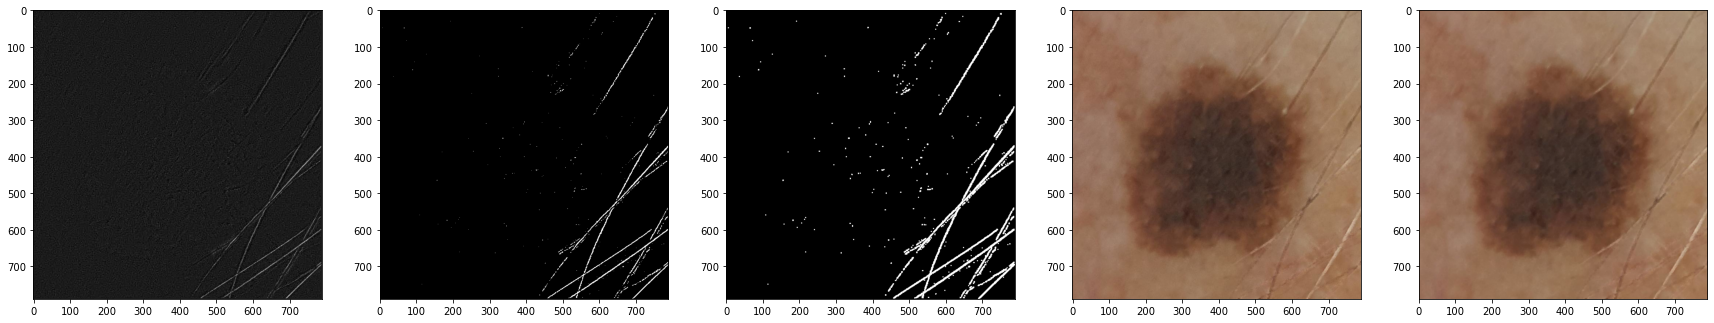

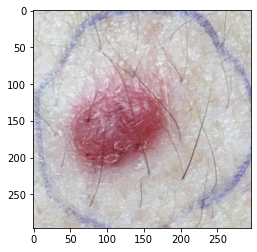

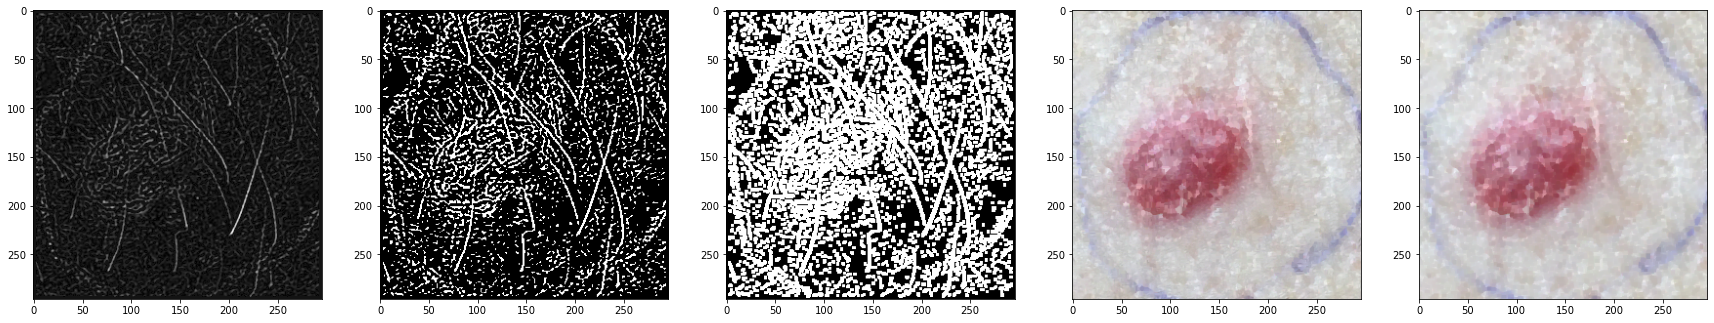

In [24]:
img = load_selected_img(7)
image_sampling.image_grid(hair_removal_dog(img),1)
img = load_selected_img(10)
image_sampling.image_grid(hair_removal_dog(img),1)


### Test: Remove light hairs as darker ones 

In [25]:
def subtract_pxs_from_channel(channel, mask):
    rows,cols=channel.shape
    for r in range(rows):
        for c in range(cols):
            if mask[r][c]!=0:
                channel[r][c]=0
    return channel

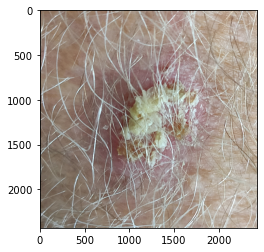

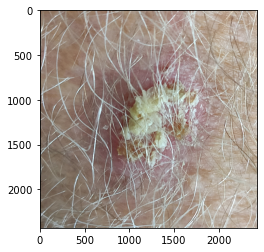

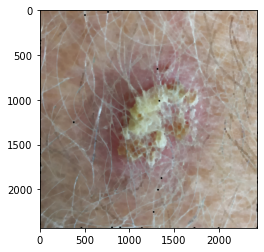

In [27]:
img = load_selected_img(2)

plt.imshow(img)
plt.show()

gray = cv2.cvtColor(img, cv2.COLOR_BGR2GRAY)
H_elems = feature.hessian_matrix(gray, sigma=1, order='rc')
result = feature.hessian_matrix_eigvals(H_elems)

img_black_hair = result[0]
img_black_hair[img_black_hair < 0] = 0

img_white_hair = -result[1]
img_white_hair[img_white_hair < 0] = 0

r, g, b = cv2.split(img)

final_r = subtract_pxs_from_channel(r,img_white_hair)
final_g = subtract_pxs_from_channel(g,img_white_hair)
final_b = subtract_pxs_from_channel(b,img_white_hair)

final = cv2.merge([final_r, final_g, final_b])

kernel = np.ones((17,17),np.uint8)
closing = cv2.morphologyEx(final, cv2.MORPH_CLOSE, kernel)
plt.imshow(closing)
plt.show()


### Test: Changing colorspace

Idea: A comprehensive survey on image-based computer aided diagnosis systems for skin cancer

https://www.researchgate.net/profile/Nazia-Hameed-2/publication/316989945_A_comprehensive_survey_on_image-based_computer_aided_diagnosis_systems_for_skin_cancer/links/5b88ff7f4585151fd13ddb1b/A-comprehensive-survey-on-image-based-computer-aided-diagnosis-systems-for-skin-cancer.pdf


In [28]:
def remove_hairs_lab_lchannel(img):

    lab = cv2.cvtColor(img, cv2.COLOR_BGR2LAB)
    l_channel, a, b = cv2.split(lab)

    kernel = cv2.getStructuringElement(1,(17,17))
    edges = cv2.morphologyEx(l_channel, cv2.MORPH_BLACKHAT, kernel)
    ret,thresh = cv2.threshold(edges,10,255,cv2.THRESH_BINARY)
    dst = cv2.inpaint(img,thresh,1,cv2.INPAINT_TELEA)
    
    return dst

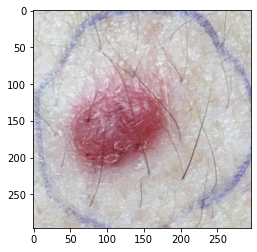

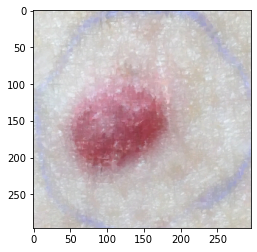

In [29]:
img = load_selected_img(10)
plt.imshow(remove_hairs_lab_lchannel(img))

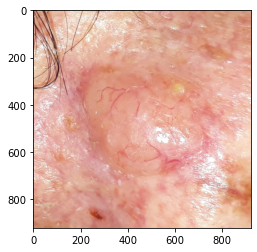

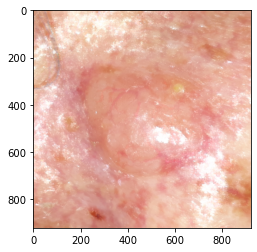

In [30]:
img = load_selected_img(6)
plt.imshow(remove_hairs_lab_lchannel(img))

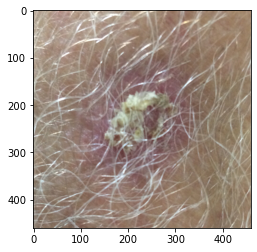

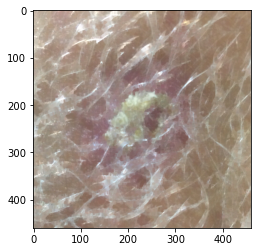

In [31]:
img = load_selected_img(0)
plt.imshow(remove_hairs_lab_lchannel(img))

In [32]:
def remove_hairs_lab_gaussian(img):
    lab = cv2.cvtColor(img, cv2.COLOR_BGR2LAB)
    l_channel, a, b = cv2.split(lab)

    H_elems = feature.hessian_matrix(l_channel, sigma=1, order='rc')
    result = feature.hessian_matrix_eigvals(H_elems)
    
    img_black_hair = result[0]
    img_black_hair[img_black_hair < 0] = 0

    img_white_hair = -result[1]
    img_white_hair[img_white_hair < 0] = 0
    
    img_paper_black_hair = (3.0 * result[0] + result[1]) / 2.0
    img_paper_white_hair = (3.0 * result[1] + result[0]) / 2.0
    
    img_paper_black_hair_t= np.float32(result[0] > 0.02)
    img_paper_white_hair_t = np.float32(result[1] < -0.02)

    ret, thresh_black = cv2.threshold(img_paper_black_hair_t, np.median(img_paper_black_hair), 255, cv2.THRESH_BINARY)
    ret, thresh_white = cv2.threshold(img_paper_white_hair_t, np.median(img_paper_white_hair), 255, cv2.THRESH_BINARY)

    dst_black = cv2.inpaint(img,img_paper_black_hair_t.astype('uint8'),2,cv2.INPAINT_TELEA)
    dst_white = cv2.inpaint(dst_black,img_paper_white_hair_t.astype('uint8'),2,cv2.INPAINT_TELEA)

    dst_black_t = cv2.inpaint(img,thresh_black.astype('uint8'),2,cv2.INPAINT_TELEA)
    dst_white_t = cv2.inpaint(img,thresh_white.astype('uint8'),2,cv2.INPAINT_TELEA)
    
    return ( dst_black, dst_white, dst_black_t, dst_white_t, thresh_black, thresh_white, img_paper_black_hair,  img_paper_white_hair, img_paper_black_hair_t, img_paper_white_hair_t )

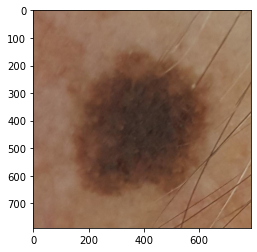

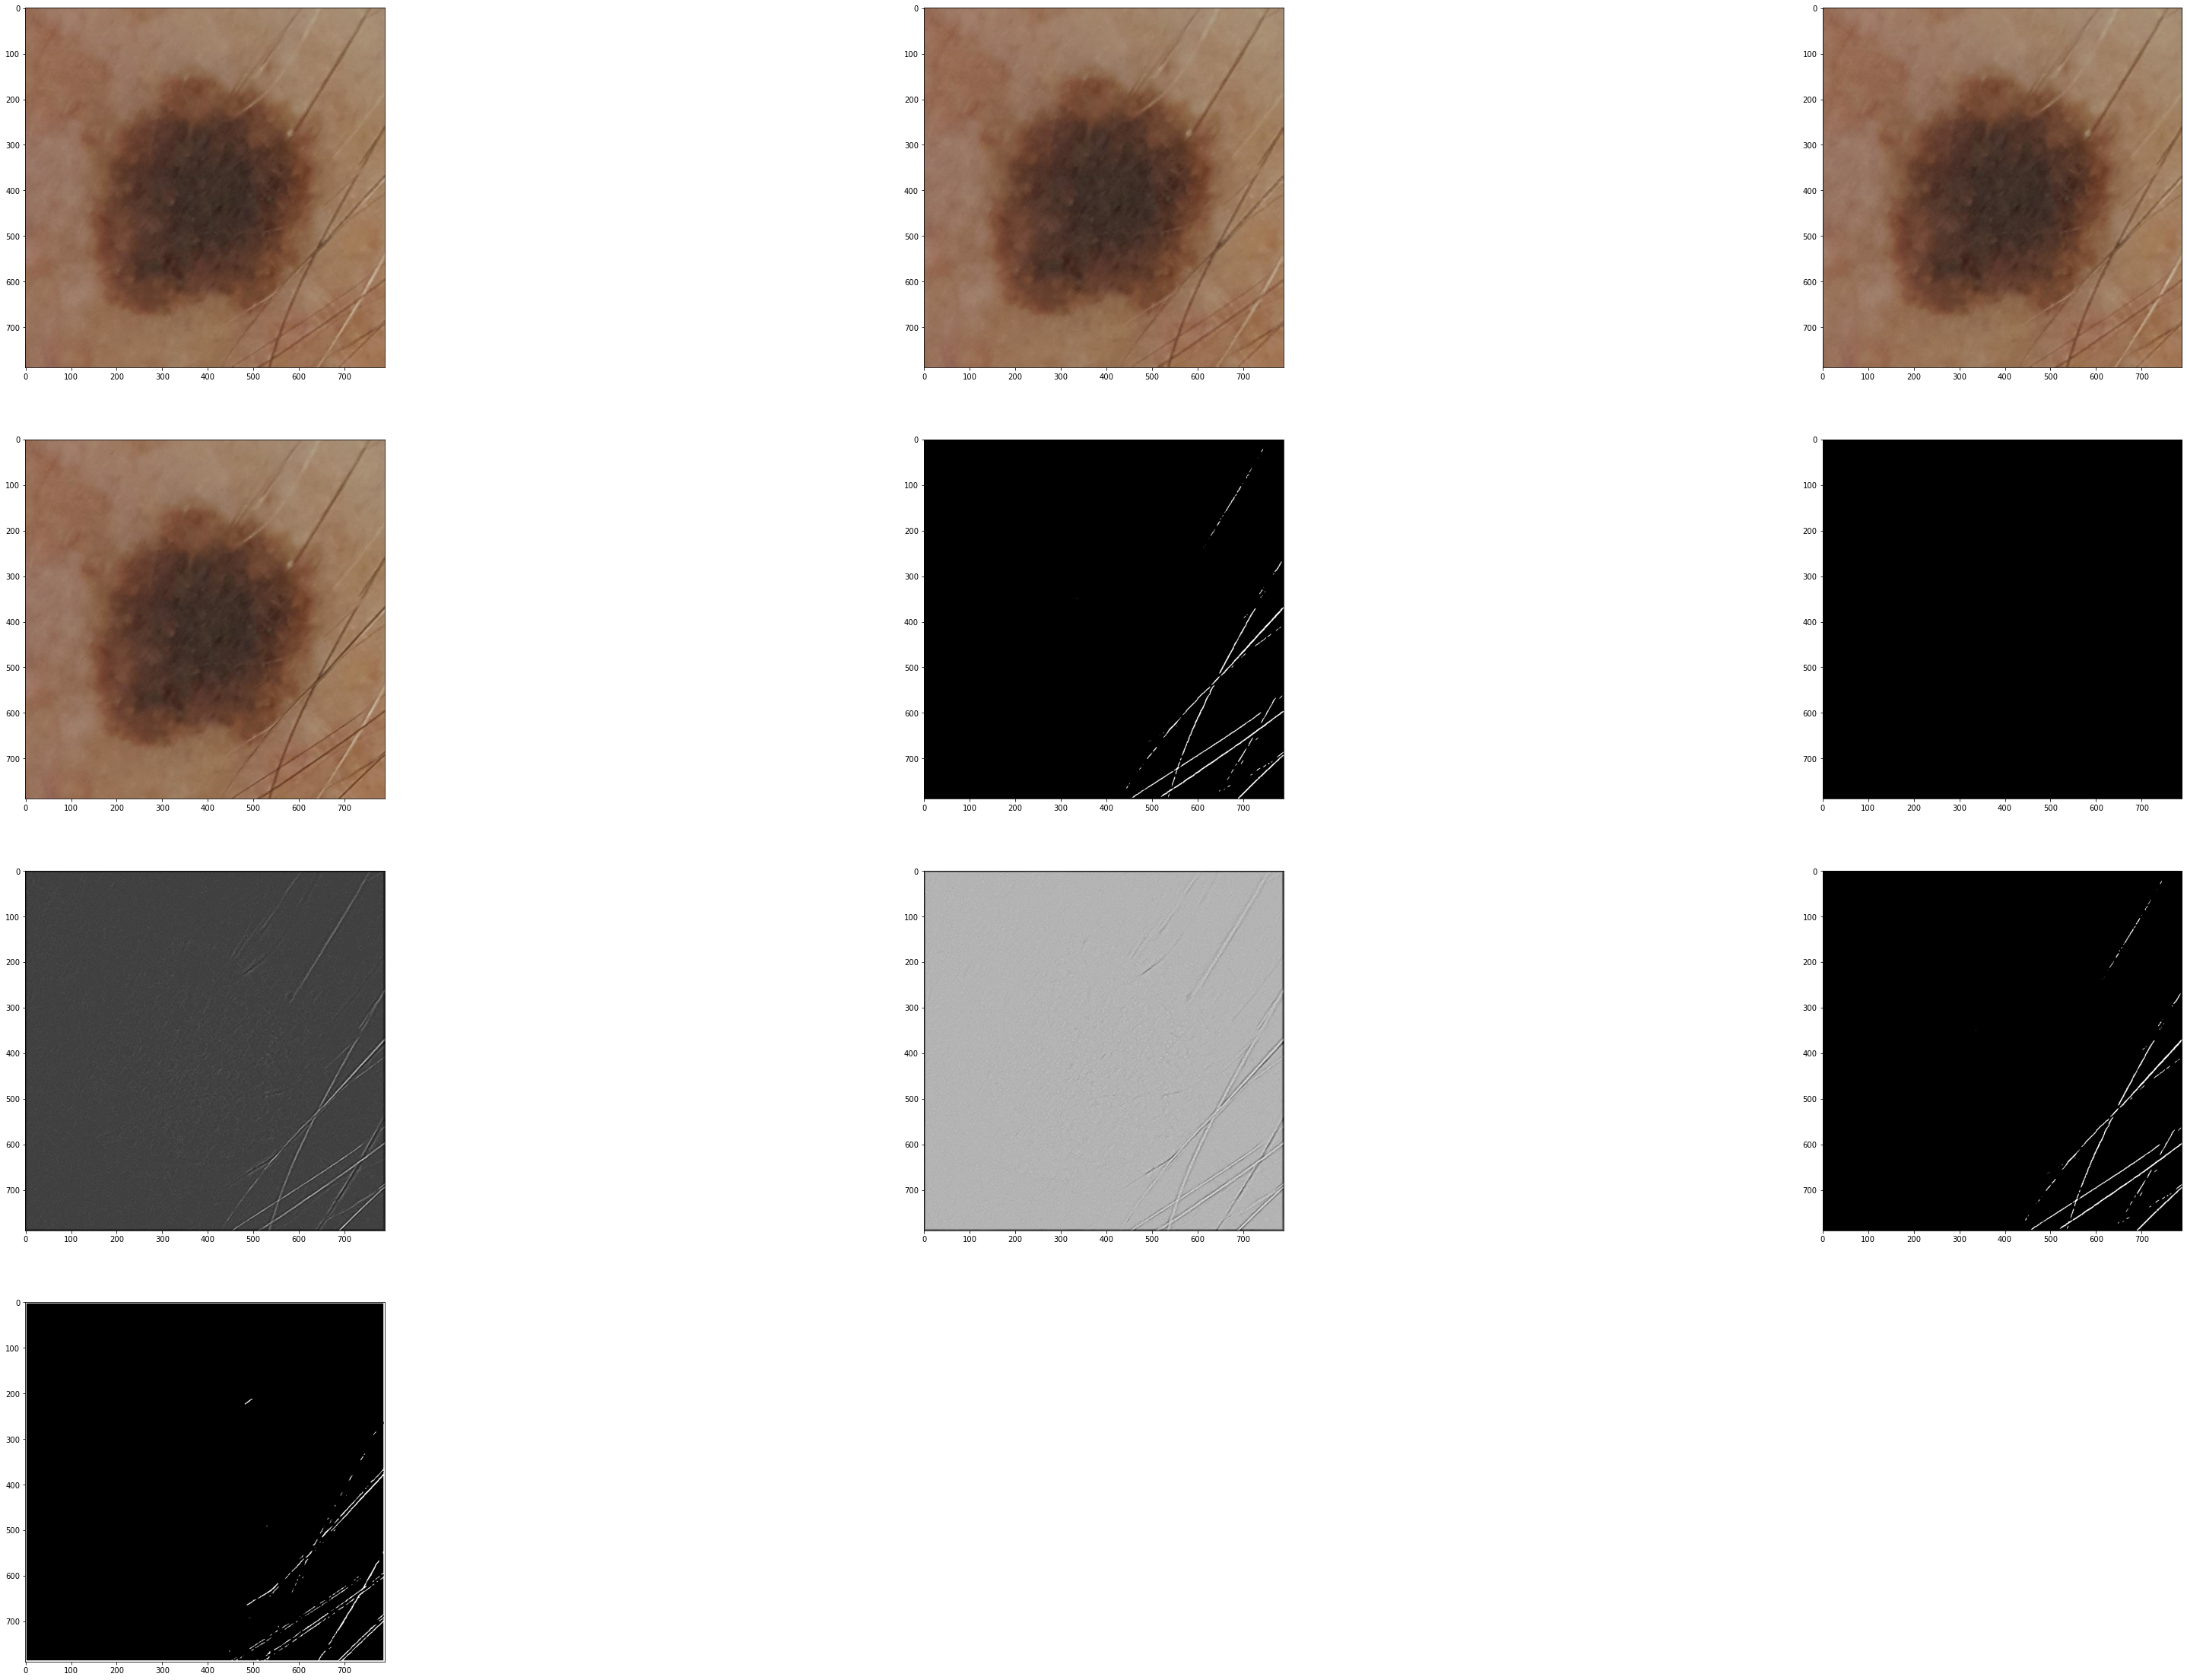

In [36]:
img = load_selected_img(7)
image_sampling.image_grid(remove_hairs_lab_gaussian(img))